<div dir="rtl">

# למידת חיזוק במערכת פיזיקלית מתייצבת - אימון סביבת הסימולציה SimNet

**שם התלמיד:** אייל פורת  
**שם המורה:** שי פרח  
**תאריך:** אפריל 2025

`SimNet` היא רשת נוירונים שנועדה לאפשר גישור בין סביבת סימולציה ממוחשבת לעולם האמיתי, לאימון רלוונטי ואיכותי יותר של הסוכן.

הרעיון הכללי, הוא שנוסחאות הפיזיקה קרובות לתיאור הרובוט, אך חידוד של חיכוכים לא לינאריים, והתנהגויות שונות לא צפויות יתאפשר עם דיוק שיעשה  בשימוש בנתוני אמת מהרובוט.

`SimNet` מקבלת מצב (state) ופעולה (action) ומנסה לחזות את המצב הבא של המערכת.

מצב המערכת כולל:
- הזווית של הרובוט (0 - עומד ישר)
- המהירות הזוויתית של הרובוט
- הפעולה הקודמת שהפעיל המנוע

במחברת זו:
- נאסוף נתונים בשימוש במשוואות פיזיקה של הרובוט (מזכיר מטוטלת הפוכה).
- נאמן על הנתונים הללו את הרשת `SimNet`.
- נבצע כיוונון (fine-tuning) של `SimNet` על נתוני אמת שנאספו מהרובוט.
</div>

In [1]:
# Uncomment the following lines to run in Google Colab

# %cd /content
# !git clone https://github.com/EyalPorat/ddpg-balancing-robot.git
# %cd ddpg-balancing-robot
# !git checkout response-time-state-1
# %cd /content/ddpg-balancing-robot/python/notebooks

# import sys
# sys.path.append('/content/ddpg-balancing-robot/python')  # Add the repo root to Python path

<div dir="rtl">

## ייבוא ספריות - Import Libraries

In [2]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
import glob
from matplotlib import pyplot as plt
import seaborn as sns

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

<div dir="rtl">

## טעינת קונפיגורציה - Configuration Loading

תחילה נטען את קבצי הקונפיגורציה המכילים את פרמטרי האימון והסביבה. באמצעותם ניתן בשלוט באופי האימון מבלי לצלול לתוך הקוד.
</div>

In [3]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

<div dir="rtl">

## Part 1: אתחול המודל והסביבה - Initialization of the Model and Environment
</div>

In [4]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

Initialized LSTMSimNet with history sizes: action=4, theta=3, theta_dot=3


c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Initialized SimNetTrainer with enhanced state (dim=12)
- theta_history_size: 3
- theta_dot_history_size: 3
- action_history_size: 4
- motor_delay_steps: 2


<div dir="rtl">

## Part 2: איסוף וניתוח נתונים מנוסחאות פיזיקה - Collecting and Analyzing Physics-Based Data

להבניית המידע הפיזיקלי הבסיסי למודל, נתחיל מאיסוף של דוגמאות מנוסחאות הפיזיקה.
</div>

In [5]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 223643 training samples
Collected 55910 validation samples


<div dir="rtl">

### ניתוח הפיזור של נתוני הפיזיקה שאספנו - Analysis of the Distribution of the Collected Physics Data

נבצע ניתוח של התפלגות הנתונים כדי להבין טוב יותר את מרחב המצבים ולזהות אזורים שעשויים להיות חסרים.
</div>

Physics data distribution statistics:
  angle_range: (-1.8792, 1.8846)
  angle_mean: -0.0047
  angle_std: 0.8799
  angular_vel_range: (-8.0024, 8.0158)
  angular_vel_mean: -0.0091
  angular_vel_std: 3.3519
  num_samples: 223643.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


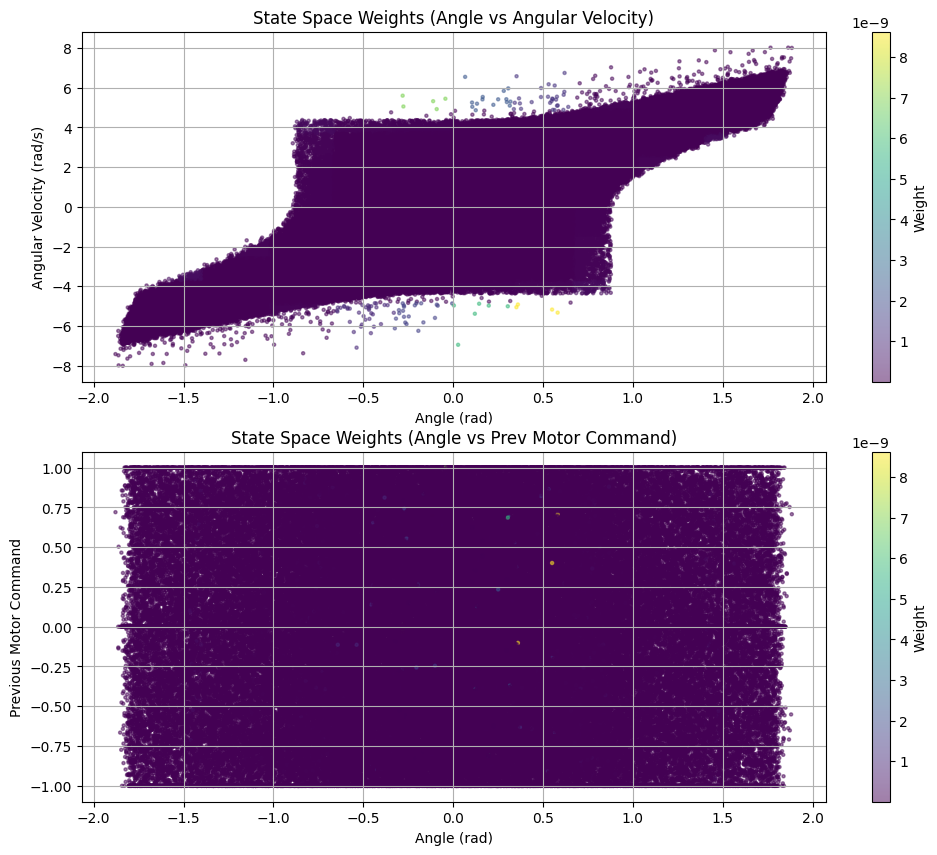

In [6]:
# Define class balancing parameters
num_bins = 10
strategy = "kmeans"

# Get distribution statistics
physics_distribution = SimNetTrainer.analyze_class_distribution(
    train_data, 
    num_bins=num_bins,
    strategy=strategy
)

print("Physics data distribution statistics:")
for key, value in physics_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights using angle and angular velocity
states = train_data['states']

# Create 2D scatter plot with first two dimensions (theta and theta_dot)
plt.figure(figsize=(12, 10))

# Create a figure with multiple subplots to show different state dimensions
plt.subplot(2, 1, 1)
weights = SimNetTrainer.calculate_class_weights(
    states, 
    num_bins=num_bins, 
    strategy=strategy
)
plt.scatter(states[:, 0], states[:, 1], c=weights, cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'State Space Weights (Angle vs Angular Velocity)')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

# Add a subplot for the angle vs prev_motor_command
plt.subplot(2, 1, 2)
plt.scatter(states[:, 0], states[:, 2], c=weights, cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'State Space Weights (Angle vs Prev Motor Command)')
plt.xlabel('Angle (rad)')
plt.ylabel('Previous Motor Command')
plt.grid(True)

<div dir="rtl">

## Part 3: אימון המודל על נתוני נוסחאות הפיזיקה - Training the Model on Physics Equations Data

</div>

In [7]:
# Train on physics data
physics_history = trainer.train(
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/1 - Train Loss: 0.638563 - Val Loss: 0.117108


In [8]:
# Save physics trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_physics_final.pt')

simnet_physics = SimNet(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dims=simnet_config['model']['hidden_dims']
)
simnet_physics.load_state_dict(torch.load(log_dir / 'simnet_physics_final.pt')['state_dict'])

Initialized LSTMSimNet with history sizes: action=4, theta=3, theta_dot=3


<All keys matched successfully>

<div dir="rtl">

## Part 4: טעינה ועיבוד של נתוני אמת מהרובוט - Loading and Processing Real-World Robot Data

</div>

In [9]:
# Find all files that start with robot_logs and end with .json
# log_files = glob.glob("../data/global_angle_robot_logs*.json")
log_files = glob.glob("../data/25hz_global_angle_robot_logs*.json")
# log_files = glob.glob("../data/global_angle_robot_logs*.json") + glob.glob("../data/25hz_global_angle_robot_logs*.json")
print(f"Found {len(log_files)} log files: {log_files}")

# Initialize empty list to store all episodes
all_episodes = []

# Load and append data from each file
for log_file in log_files:
    with open(log_file, "r") as f:
        log_data = json.load(f)
        # Append episodes from this file
        # drop the first and last data point from each episode
        for episode in log_data["episodes"]:
            for key in episode.keys():
                if isinstance(episode[key], list):  # Check if the value is a list
                    episode[key] = episode[key][1:-1]
        # Append the modified episode to all_episodes
        all_episodes.extend(log_data["episodes"])
        print(f"Loaded {len(log_data['episodes'])} episodes from {log_file}")

# Process combined data
real_train_data, real_val_data = trainer.process_real_data(all_episodes)
print(f"Processed {len(real_train_data['states'])} real training samples")
print(f"Processed {len(real_val_data['states'])} real validation samples")

real_train_data = trainer.clean_data_exceptions(real_train_data, 6)
print(f"Cleaned real training data: {len(real_train_data['states'])} samples")

Found 6 log files: ['../data\\25hz_global_angle_robot_logs_20250511_013958_with_action.json', '../data\\25hz_global_angle_robot_logs_20250511_014549_no_motor.json', '../data\\25hz_global_angle_robot_logs_20250511_020145_different_actions.json', '../data\\25hz_global_angle_robot_logs_20250511_022200_with_motor.json', '../data\\25hz_global_angle_robot_logs_20250514_012650_with_DDPG_control.json', '../data\\25hz_global_angle_robot_logs_20250515_171902_no_action.json']
Loaded 32 episodes from ../data\25hz_global_angle_robot_logs_20250511_013958_with_action.json
Loaded 21 episodes from ../data\25hz_global_angle_robot_logs_20250511_014549_no_motor.json
Loaded 62 episodes from ../data\25hz_global_angle_robot_logs_20250511_020145_different_actions.json
Loaded 16 episodes from ../data\25hz_global_angle_robot_logs_20250511_022200_with_motor.json
Loaded 16 episodes from ../data\25hz_global_angle_robot_logs_20250514_012650_with_DDPG_control.json
Loaded 8 episodes from ../data\25hz_global_angle_rob

<div dir="rtl">

## הצגה וניתוח של נתוני האמת - Visualization and Analysis of Real-World Data

נציג בגרף של ערך לזמן, את הפרקים שנאספו מהרובוט. נבחן גרפים של הזווית, המהירות הזוויתית ופלט המנוע.
</div>

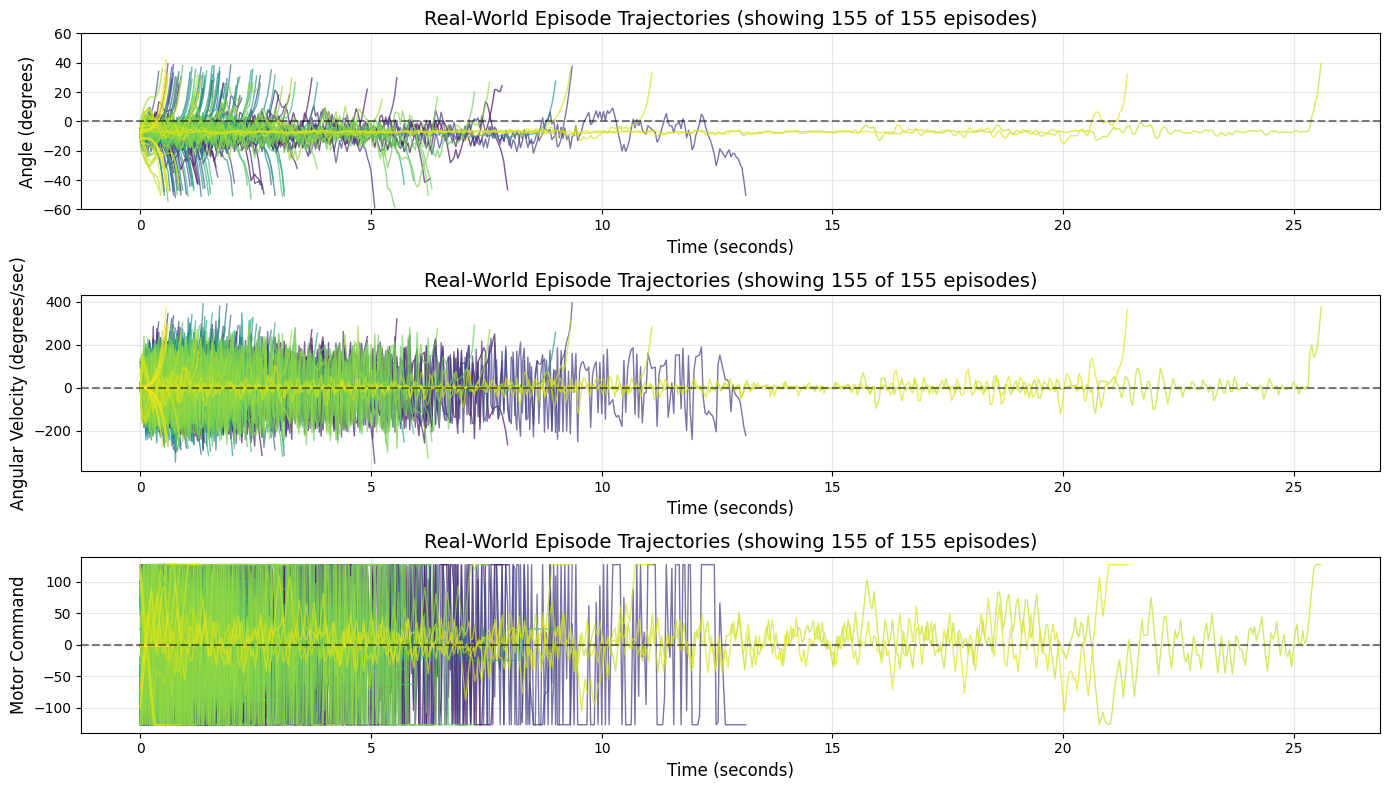

In [10]:
# Plot trajectories of all real-world episodes (angle vs time)
plt.figure(figsize=(14, 8))

# Track the number of plotted episodes
plotted_episodes = 0
max_episodes_to_show = 10000  # Limit to avoid overcrowding

# Define color palette for better visualization
colors = plt.cm.viridis(np.linspace(0, 1, min(len(all_episodes), max_episodes_to_show)))

# Iterate through all real-world episodes
for i, episode in enumerate(all_episodes):
    # Skip if we've reached the limit
    if plotted_episodes >= max_episodes_to_show:
        break

    # Extract states
    if "states" not in episode or not episode["states"]:
        continue

    states = episode["states"]

    # Extract timestamps and angles
    timestamps = []
    angles_deg = []
    angular_vels_dps = []
    motor_commands = []

    # Get the initial timestamp to normalize
    if len(states) > 0 and "timestamp" in states[0]:
        start_time = states[0]["timestamp"]
    else:
        continue  # Skip if no timestamp

    # Process each state
    for state in states:
        if "timestamp" in state and "theta" in state:
            # Convert to seconds from start of episode
            time_sec = (state["timestamp"] - start_time) / 1000.0
            # Convert angle to degrees
            angle_deg = state["theta_global"] * 180 / np.pi
            # Convert angular velocity to degrees per second
            angular_vel_degps = state["theta_dot"] * 180 / np.pi

            timestamps.append(time_sec)
            angles_deg.append(angle_deg)
            angular_vels_dps.append(angular_vel_degps)
            motor_commands.append(state["motor_pwm"])

    plt.subplot(3, 1, 1)
    plt.plot(timestamps, angles_deg, color=colors[plotted_episodes], alpha=0.7, linewidth=1.0)
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, angular_vels_dps, color=colors[plotted_episodes], alpha=0.7, linewidth=1.0)
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, motor_commands, color=colors[plotted_episodes], alpha=0.7, linewidth=1.0)

    plotted_episodes += 1

# Customize plot
plt.subplot(3, 1, 1)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Angle (degrees)", fontsize=12)
plt.title(f"Real-World Episode Trajectories (showing {plotted_episodes} of {len(all_episodes)} episodes)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)  # Add horizontal line at 0 degrees (balanced position)

# Add y-axis limits to focus on typical balancing range
plt.ylim(-60, 60)  # Adjust based on your data

plt.subplot(3, 1, 2)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Angular Velocity (degrees/sec)", fontsize=12)
plt.title(f"Real-World Episode Trajectories (showing {plotted_episodes} of {len(all_episodes)} episodes)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)  # Add horizontal line at 0 degrees (balanced position)

plt.subplot(3, 1, 3)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Motor Command", fontsize=12)
plt.title(f"Real-World Episode Trajectories (showing {plotted_episodes} of {len(all_episodes)} episodes)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)  # Add horizontal line at 0 degrees (balanced position)


plt.tight_layout()
plt.savefig(log_dir / "real_world_trajectories.png")
plt.show()

<div dir="rtl">

## ניתוח ואיזון התפלגות נתוני האמת - Analysis and Balance of Real-World Data Distribution

ביחס לנתונים שנאספו מנוסחאות הפיזיקה, שנוצרו בצורה אחידה, נתוני האמת יכולים להיות מפוזרים אחרת, ודלילים יותר במקומות מסוימים. לקבלת אימון איכותי נאזן אותם.
</div>

Real-world data distribution statistics:
  angle_range: (-0.8038, 0.5004)
  angle_mean: -0.1287
  angle_std: 0.1304
  angular_vel_range: (-6.0376, 5.6598)
  angular_vel_mean: 0.0646
  angular_vel_std: 1.8994
  num_samples: 7911.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


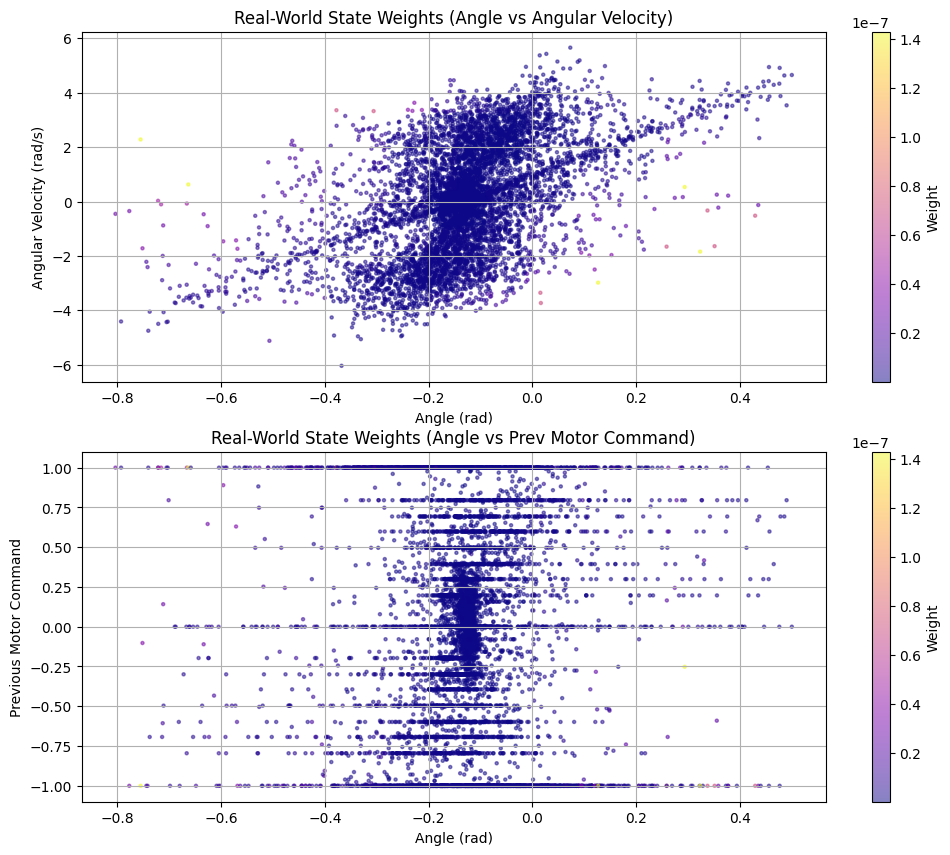

In [11]:
num_bins = 10
strategy = "kmeans"

# Analyze the class distribution of real data
real_distribution = SimNetTrainer.analyze_class_distribution(real_train_data, num_bins=num_bins, strategy=strategy)

print("Real-world data distribution statistics:")
for key, value in real_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights for real data
real_states = real_train_data["states"]
real_weights = SimNetTrainer.calculate_class_weights(real_states, num_bins=num_bins, strategy=strategy)

# Create multi-dimensional visualization for real data
plt.figure(figsize=(12, 10))

# Plot angle vs angular velocity
plt.subplot(2, 1, 1)
plt.scatter(real_states[:, 0], real_states[:, 1], c=real_weights, cmap="plasma", alpha=0.5, s=5)
plt.colorbar(label="Weight")
plt.title(f"Real-World State Weights (Angle vs Angular Velocity)")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)

# Plot angle vs previous motor command
plt.subplot(2, 1, 2)
plt.scatter(real_states[:, 0], real_states[:, 2], c=real_weights, cmap="plasma", alpha=0.5, s=5)
plt.colorbar(label="Weight")
plt.title(f"Real-World State Weights (Angle vs Prev Motor Command)")
plt.xlabel("Angle (rad)")
plt.ylabel("Previous Motor Command")
plt.grid(True)

Data shape: (7911, 12), Actions shape: (7911, 1)
Min/Max Angle: -0.8038 to 0.5004 radians
Min/Max Angular Velocity: -6.0376 to 5.6598 rad/s
Min/Max Action: -1.0000 to 1.0000
Average delta angle: 0.001666 radians
Average delta angular velocity: 0.018503 rad/s

Detailed Statistics:
  angle_mean: -0.128735
  angle_std: 0.130394
  theta_dot_mean: 0.064639
  theta_dot_std: 1.899388
  action_mean: 0.014152
  action_std: 0.682900
  delta_theta_mean: 0.001666
  delta_theta_std: 0.076815
  delta_theta_dot_mean: 0.018503
  delta_theta_dot_std: 2.902197


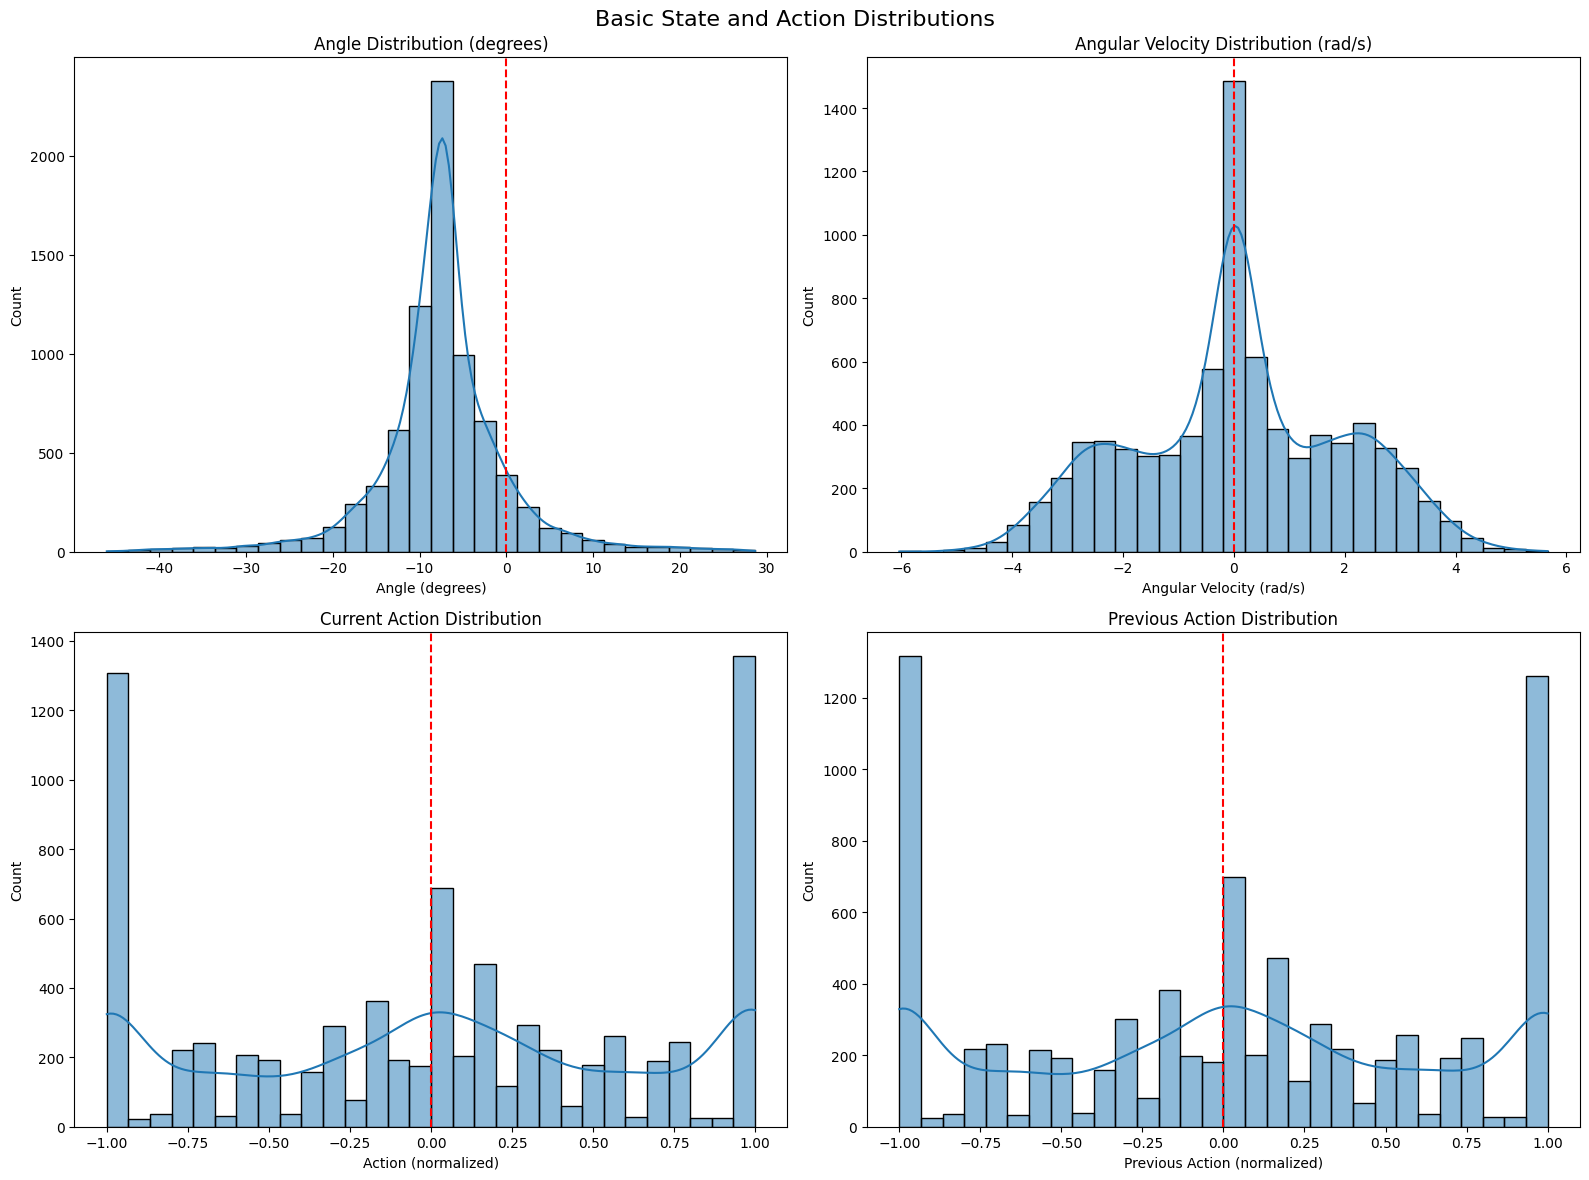

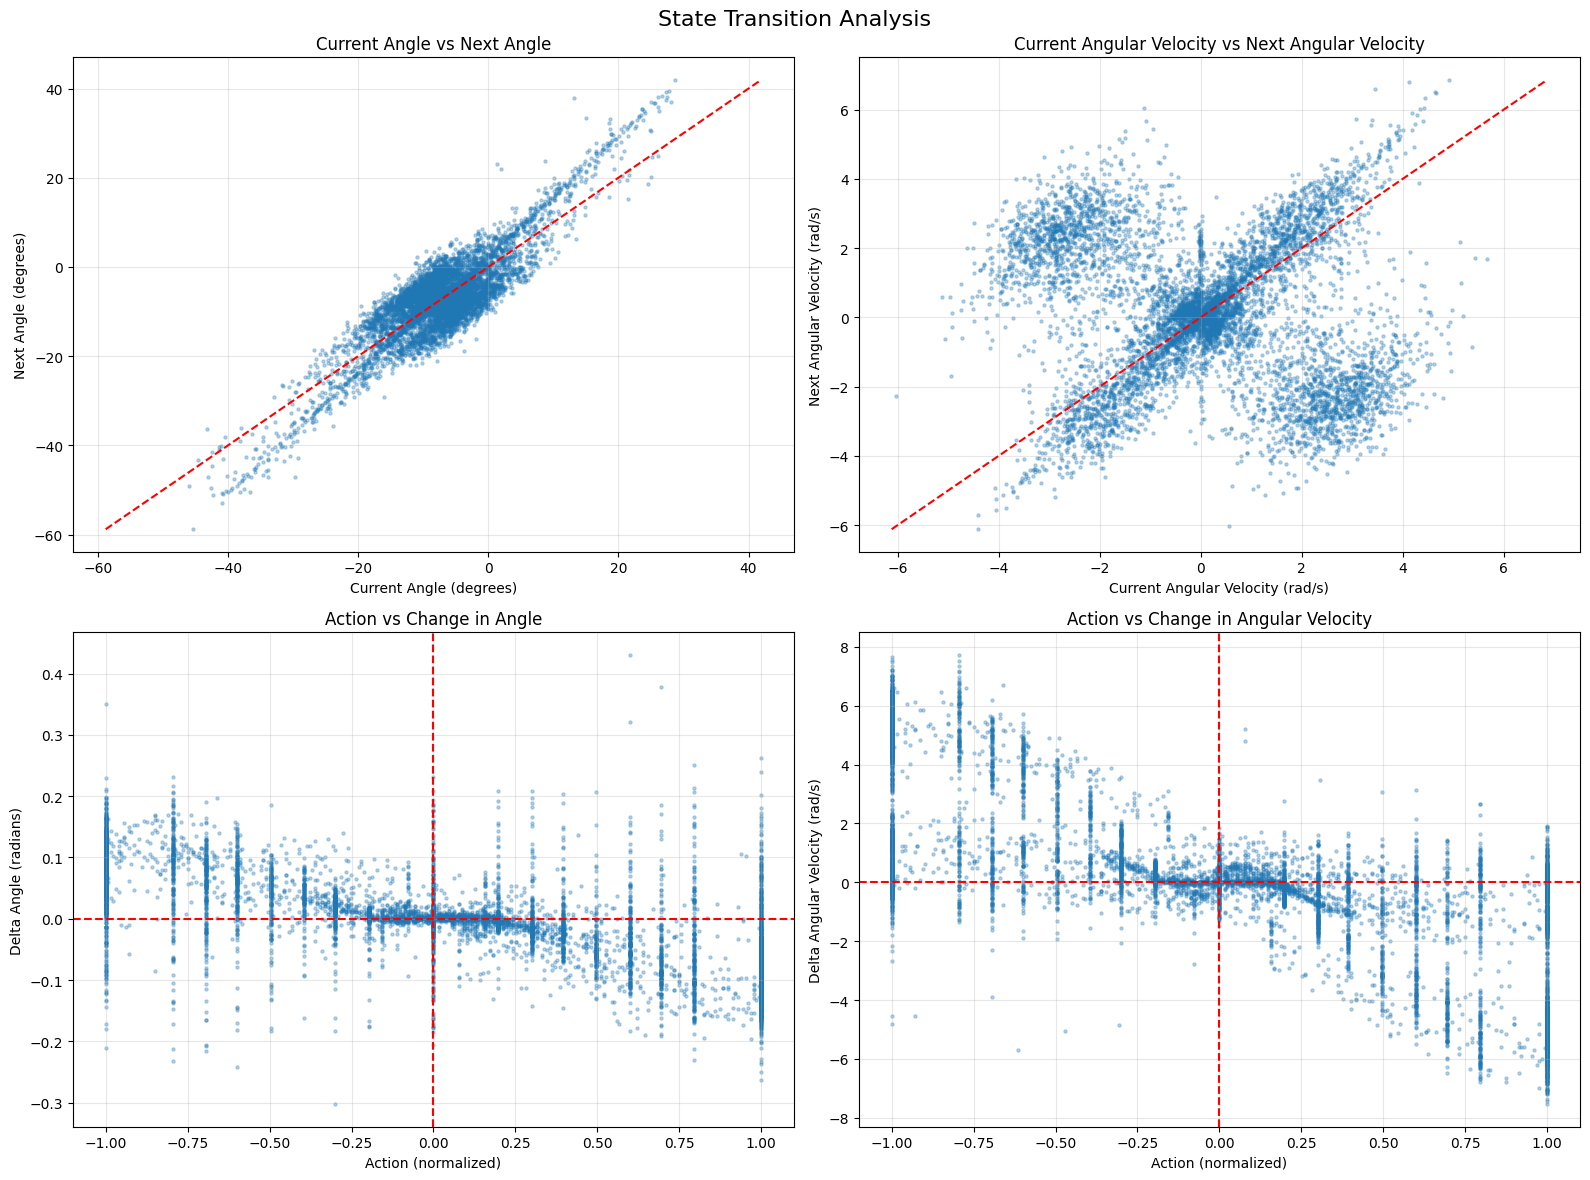

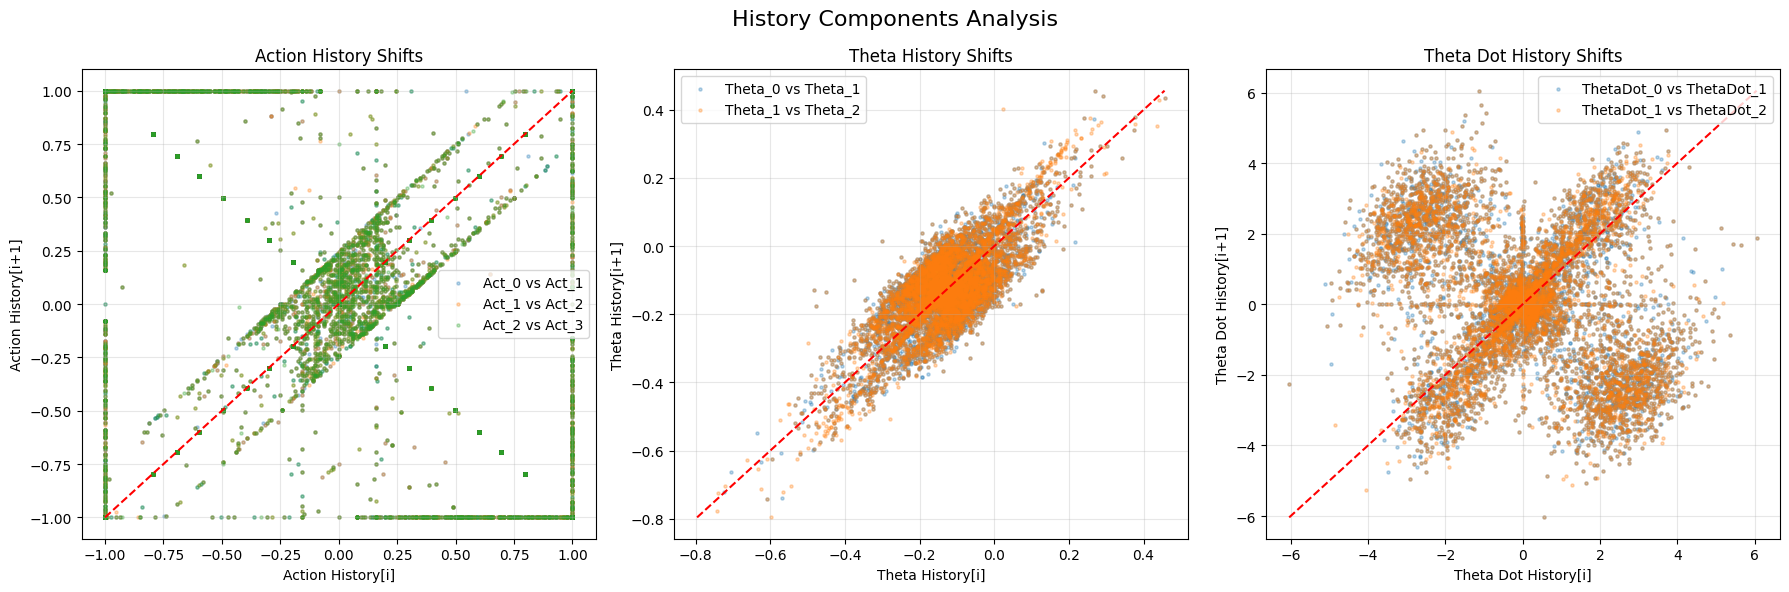

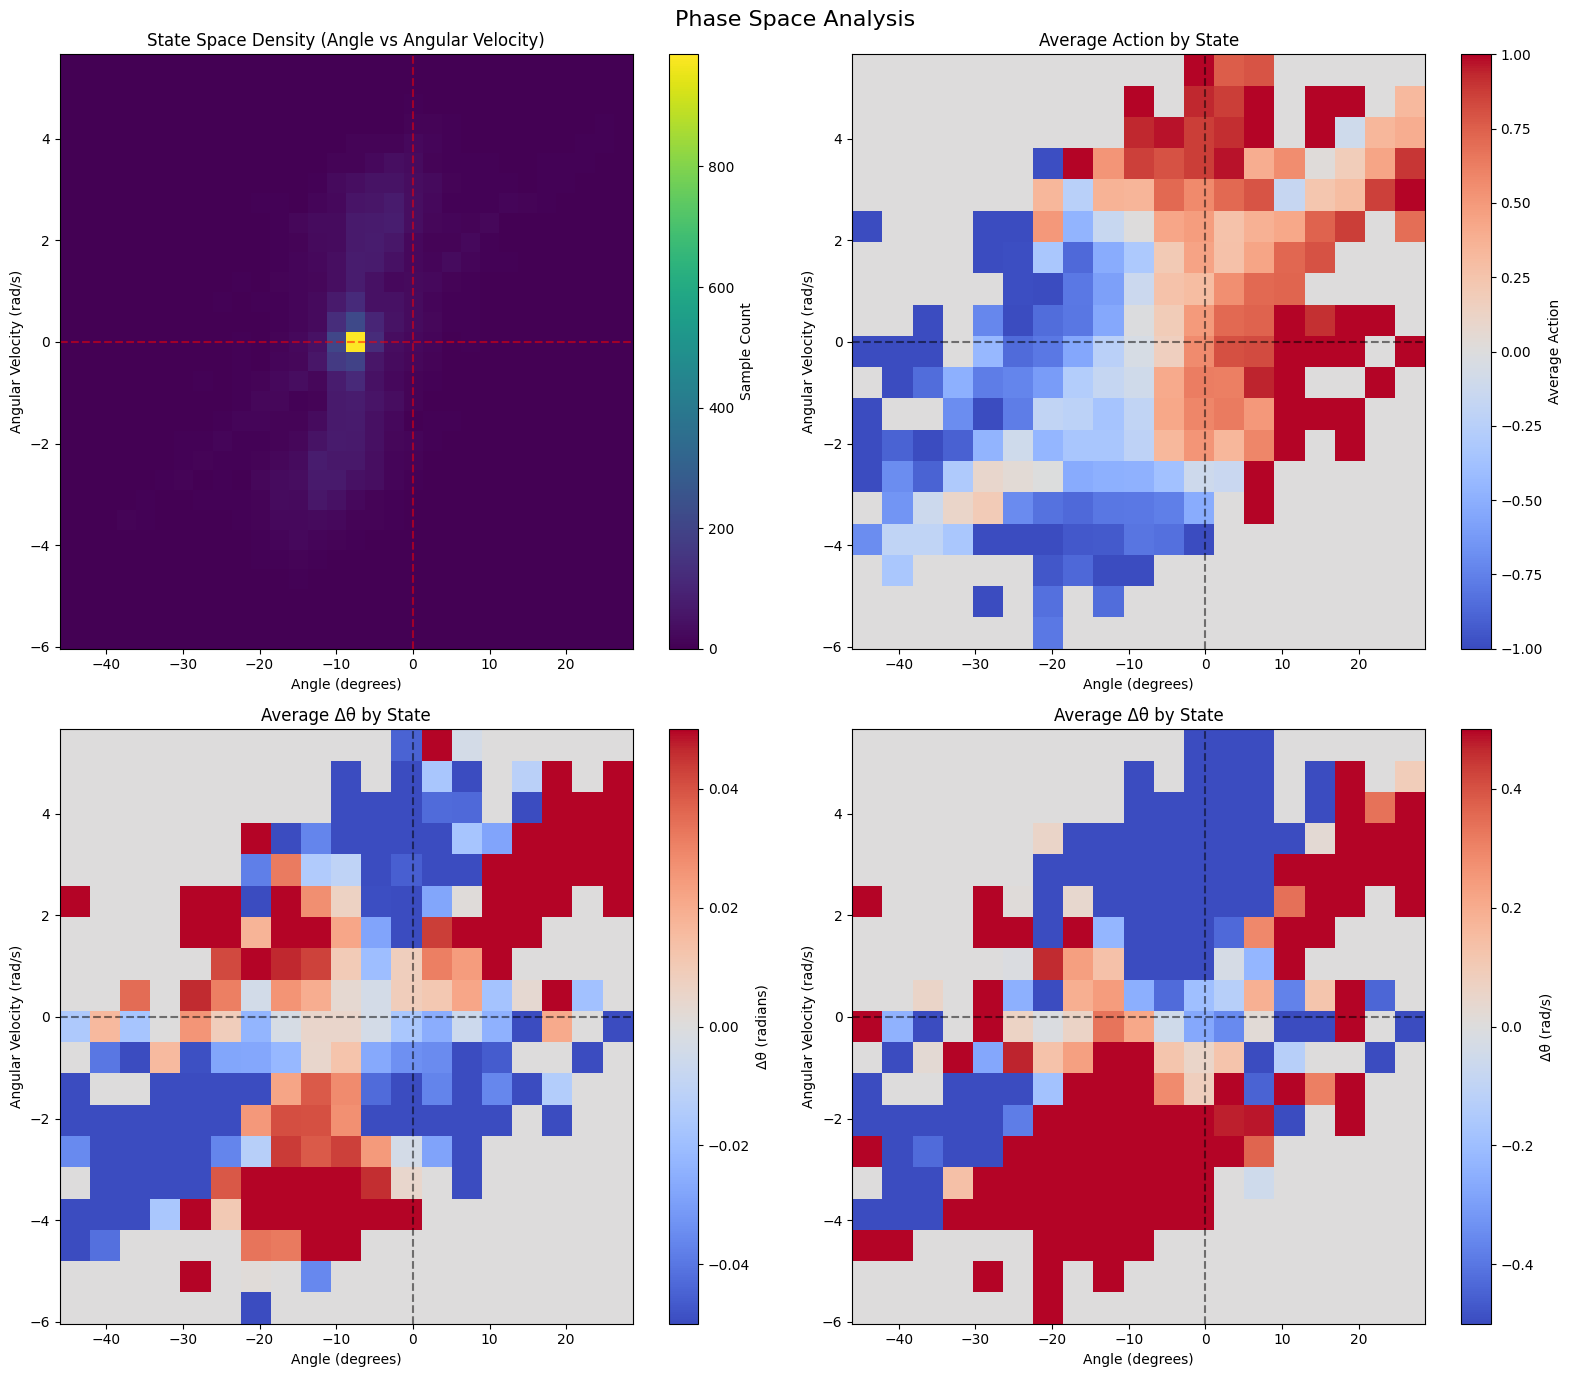

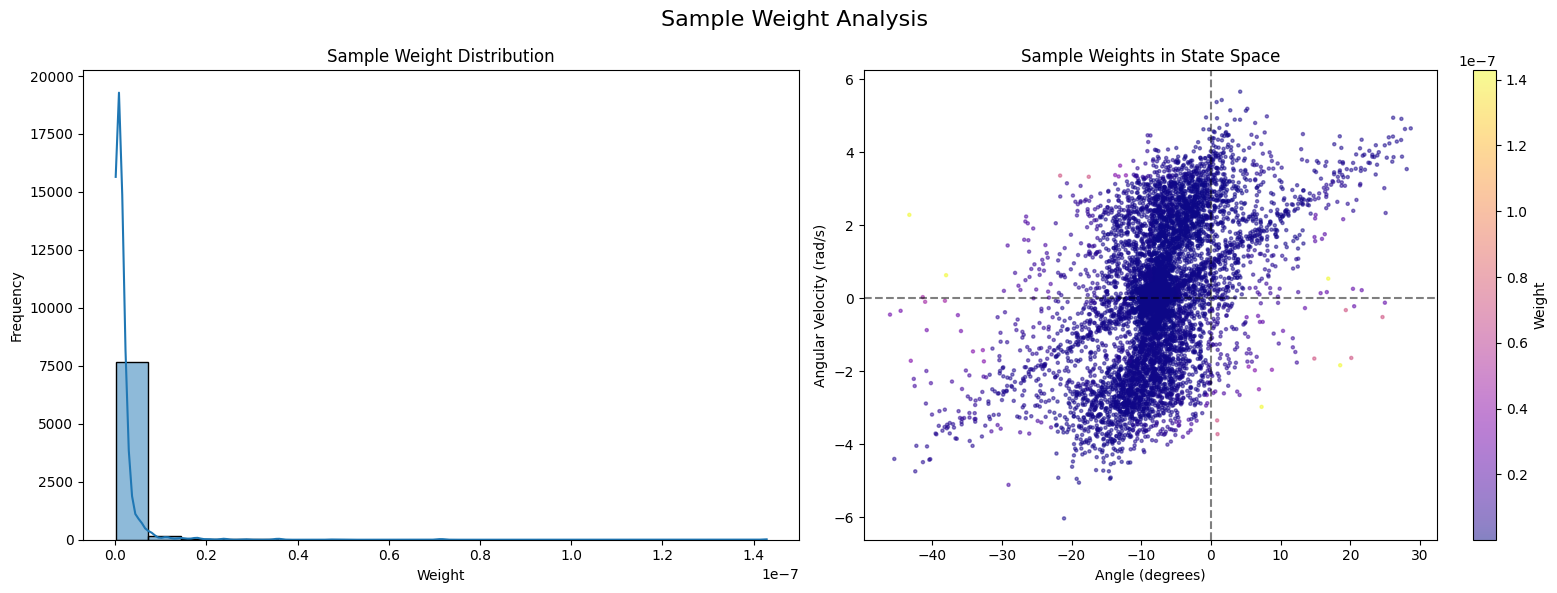

In [12]:
import pandas as pd

def analyze_real_data_distribution(real_train_data, num_bins=10, strategy="kmeans"):
    """
    Comprehensive analysis of real data distribution with focus on state transitions.
    
    Args:
        real_train_data: Dictionary with 'states', 'actions', and 'next_states'
        num_bins: Number of bins for discretization
        strategy: Binning strategy ('uniform', 'quantile', or 'kmeans')
        
    Returns:
        Dictionary with distribution statistics and figures
    """
    # Get the data arrays
    states = real_train_data["states"]
    actions = real_train_data["actions"]
    next_states = real_train_data["next_states"]
    
    # Extract basic state components
    thetas = states[:, 0]  # Angle
    theta_dots = states[:, 1]  # Angular velocity
    prev_actions = states[:, 2]  # Previous motor command (first element of history)
    
    # Extract basic next state components
    next_thetas = next_states[:, 0]  # Next angle
    next_theta_dots = next_states[:, 1]  # Next angular velocity
    
    # Extract basic history components
    action_history = states[:, 2:2+4]  # Assuming 4 action history elements
    theta_history = states[:, 2+4:2+4+3]  # Assuming 3 theta history elements
    theta_dot_history = states[:, 2+4+3:2+4+3+3]  # Assuming 3 theta_dot history elements
    
    # Calculate delta states (changes)
    delta_thetas = next_thetas - thetas
    delta_theta_dots = next_theta_dots - theta_dots
    
    print(f"Data shape: {states.shape}, Actions shape: {actions.shape}")
    print(f"Min/Max Angle: {np.min(thetas):.4f} to {np.max(thetas):.4f} radians")
    print(f"Min/Max Angular Velocity: {np.min(theta_dots):.4f} to {np.max(theta_dots):.4f} rad/s")
    print(f"Min/Max Action: {np.min(actions):.4f} to {np.max(actions):.4f}")
    print(f"Average delta angle: {np.mean(delta_thetas):.6f} radians")
    print(f"Average delta angular velocity: {np.mean(delta_theta_dots):.6f} rad/s")
    
    # Create a dataframe for easier analysis
    df = pd.DataFrame({
        'theta': thetas,
        'theta_deg': thetas * 180/np.pi,  # Convert to degrees for readability
        'theta_dot': theta_dots,
        'prev_action': prev_actions,
        'action': actions.flatten(),
        'next_theta': next_thetas,
        'next_theta_deg': next_thetas * 180/np.pi,
        'next_theta_dot': next_theta_dots,
        'delta_theta': delta_thetas,
        'delta_theta_dot': delta_theta_dots
    })
    
    # Create figures to return
    figures = {}
    
    # 1. Basic distribution histograms
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle('Basic State and Action Distributions', fontsize=16)
    
    sns.histplot(df['theta_deg'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Angle Distribution (degrees)')
    axes[0, 0].set_xlabel('Angle (degrees)')
    axes[0, 0].axvline(0, color='red', linestyle='--')
    
    sns.histplot(df['theta_dot'], bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Angular Velocity Distribution (rad/s)')
    axes[0, 1].set_xlabel('Angular Velocity (rad/s)')
    axes[0, 1].axvline(0, color='red', linestyle='--')
    
    sns.histplot(df['action'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Current Action Distribution')
    axes[1, 0].set_xlabel('Action (normalized)')
    axes[1, 0].axvline(0, color='red', linestyle='--')
    
    sns.histplot(df['prev_action'], bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Previous Action Distribution')
    axes[1, 1].set_xlabel('Previous Action (normalized)')
    axes[1, 1].axvline(0, color='red', linestyle='--')
    
    plt.tight_layout()
    figures['basic_distributions'] = fig1
    
    # 2. State transition analysis
    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle('State Transition Analysis', fontsize=16)
    
    # Angle vs Next Angle
    axes[0, 0].scatter(df['theta_deg'], df['next_theta_deg'], alpha=0.3, s=5)
    angle_min = min(df['theta_deg'].min(), df['next_theta_deg'].min())
    angle_max = max(df['theta_deg'].max(), df['next_theta_deg'].max())
    axes[0, 0].plot([angle_min, angle_max], [angle_min, angle_max], 'r--')
    axes[0, 0].set_title('Current Angle vs Next Angle')
    axes[0, 0].set_xlabel('Current Angle (degrees)')
    axes[0, 0].set_ylabel('Next Angle (degrees)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Angular Velocity vs Next Angular Velocity
    axes[0, 1].scatter(df['theta_dot'], df['next_theta_dot'], alpha=0.3, s=5)
    vel_min = min(df['theta_dot'].min(), df['next_theta_dot'].min())
    vel_max = max(df['theta_dot'].max(), df['next_theta_dot'].max())
    axes[0, 1].plot([vel_min, vel_max], [vel_min, vel_max], 'r--')
    axes[0, 1].set_title('Current Angular Velocity vs Next Angular Velocity')
    axes[0, 1].set_xlabel('Current Angular Velocity (rad/s)')
    axes[0, 1].set_ylabel('Next Angular Velocity (rad/s)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Action vs Delta Angle
    axes[1, 0].scatter(df['action'], df['delta_theta'], alpha=0.3, s=5)
    axes[1, 0].axhline(0, color='r', linestyle='--')
    axes[1, 0].axvline(0, color='r', linestyle='--')
    axes[1, 0].set_title('Action vs Change in Angle')
    axes[1, 0].set_xlabel('Action (normalized)')
    axes[1, 0].set_ylabel('Delta Angle (radians)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Action vs Delta Angular Velocity
    axes[1, 1].scatter(df['action'], df['delta_theta_dot'], alpha=0.3, s=5)
    axes[1, 1].axhline(0, color='r', linestyle='--')
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Action vs Change in Angular Velocity')
    axes[1, 1].set_xlabel('Action (normalized)')
    axes[1, 1].set_ylabel('Delta Angular Velocity (rad/s)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    figures['transition_analysis'] = fig2
    
    # 3. History component analysis
    fig3, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig3.suptitle('History Components Analysis', fontsize=16)
    
    # Action history shifts
    for i in range(min(3, action_history.shape[1]-1)):
        axes[0].scatter(action_history[:, i], action_history[:, i+1], 
                      alpha=0.3, s=5, label=f'Act_{i} vs Act_{i+1}')
    axes[0].plot([-1, 1], [-1, 1], 'r--')
    axes[0].set_title('Action History Shifts')
    axes[0].set_xlabel('Action History[i]')
    axes[0].set_ylabel('Action History[i+1]')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Theta history shifts
    for i in range(min(2, theta_history.shape[1]-1)):
        axes[1].scatter(theta_history[:, i], theta_history[:, i+1], 
                      alpha=0.3, s=5, label=f'Theta_{i} vs Theta_{i+1}')
    theta_min = theta_history.min()
    theta_max = theta_history.max()
    axes[1].plot([theta_min, theta_max], [theta_min, theta_max], 'r--')
    axes[1].set_title('Theta History Shifts')
    axes[1].set_xlabel('Theta History[i]')
    axes[1].set_ylabel('Theta History[i+1]')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Theta dot history shifts
    for i in range(min(2, theta_dot_history.shape[1]-1)):
        axes[2].scatter(theta_dot_history[:, i], theta_dot_history[:, i+1], 
                      alpha=0.3, s=5, label=f'ThetaDot_{i} vs ThetaDot_{i+1}')
    theta_dot_min = theta_dot_history.min()
    theta_dot_max = theta_dot_history.max()
    axes[2].plot([theta_dot_min, theta_dot_max], [theta_dot_min, theta_dot_max], 'r--')
    axes[2].set_title('Theta Dot History Shifts')
    axes[2].set_xlabel('Theta Dot History[i]')
    axes[2].set_ylabel('Theta Dot History[i+1]')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    figures['history_shifts'] = fig3
    
    # 4. Phase space and action heatmap
    fig4, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig4.suptitle('Phase Space Analysis', fontsize=16)
    
    # 2D histogram of state space (angle vs angular velocity)
    h = axes[0, 0].hist2d(df['theta_deg'], df['theta_dot'], bins=30, cmap='viridis')
    axes[0, 0].set_title('State Space Density (Angle vs Angular Velocity)')
    axes[0, 0].set_xlabel('Angle (degrees)')
    axes[0, 0].set_ylabel('Angular Velocity (rad/s)')
    axes[0, 0].axhline(0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].axvline(0, color='r', linestyle='--', alpha=0.5)
    plt.colorbar(h[3], ax=axes[0, 0], label='Sample Count')
    
    # Action heatmap by state
    theta_bins = np.linspace(df['theta_deg'].min(), df['theta_deg'].max(), 20)
    theta_dot_bins = np.linspace(df['theta_dot'].min(), df['theta_dot'].max(), 20)
    
    # Create 2D grid
    theta_centers = (theta_bins[:-1] + theta_bins[1:]) / 2
    theta_dot_centers = (theta_dot_bins[:-1] + theta_dot_bins[1:]) / 2
    action_grid = np.zeros((len(theta_centers), len(theta_dot_centers)))
    count_grid = np.zeros_like(action_grid)
    
    # Assign actions to grid cells
    for idx, row in df.iterrows():
        theta_idx = np.digitize(row['theta_deg'], theta_bins) - 1
        theta_dot_idx = np.digitize(row['theta_dot'], theta_dot_bins) - 1
        
        if 0 <= theta_idx < len(theta_centers) and 0 <= theta_dot_idx < len(theta_dot_centers):
            action_grid[theta_idx, theta_dot_idx] += row['action']
            count_grid[theta_idx, theta_dot_idx] += 1
    
    # Average actions in each cell
    with np.errstate(divide='ignore', invalid='ignore'):
        action_grid = np.divide(action_grid, count_grid)
        action_grid = np.nan_to_num(action_grid)
    
    # Plot action heatmap
    im = axes[0, 1].pcolormesh(theta_centers, theta_dot_centers, action_grid.T, 
                             cmap='coolwarm', vmin=-1, vmax=1)
    axes[0, 1].set_title('Average Action by State')
    axes[0, 1].set_xlabel('Angle (degrees)')
    axes[0, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[0, 1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[0, 1].axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.colorbar(im, ax=axes[0, 1], label='Average Action')
    
    # Delta theta heatmap by state
    delta_theta_grid = np.zeros((len(theta_centers), len(theta_dot_centers)))
    
    # Assign delta thetas to grid cells
    for idx, row in df.iterrows():
        theta_idx = np.digitize(row['theta_deg'], theta_bins) - 1
        theta_dot_idx = np.digitize(row['theta_dot'], theta_dot_bins) - 1
        
        if 0 <= theta_idx < len(theta_centers) and 0 <= theta_dot_idx < len(theta_dot_centers):
            delta_theta_grid[theta_idx, theta_dot_idx] += row['delta_theta']
    
    # Average delta thetas in each cell
    with np.errstate(divide='ignore', invalid='ignore'):
        delta_theta_grid = np.divide(delta_theta_grid, count_grid)
        delta_theta_grid = np.nan_to_num(delta_theta_grid)
    
    # Plot delta theta heatmap
    im = axes[1, 0].pcolormesh(theta_centers, theta_dot_centers, delta_theta_grid.T, 
                             cmap='coolwarm', vmin=-0.05, vmax=0.05)
    axes[1, 0].set_title('Average Δθ by State')
    axes[1, 0].set_xlabel('Angle (degrees)')
    axes[1, 0].set_ylabel('Angular Velocity (rad/s)')
    axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1, 0].axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.colorbar(im, ax=axes[1, 0], label='Δθ (radians)')
    
    # Delta theta_dot heatmap by state
    delta_theta_dot_grid = np.zeros((len(theta_centers), len(theta_dot_centers)))
    
    # Assign delta theta_dots to grid cells
    for idx, row in df.iterrows():
        theta_idx = np.digitize(row['theta_deg'], theta_bins) - 1
        theta_dot_idx = np.digitize(row['theta_dot'], theta_dot_bins) - 1
        
        if 0 <= theta_idx < len(theta_centers) and 0 <= theta_dot_idx < len(theta_dot_centers):
            delta_theta_dot_grid[theta_idx, theta_dot_idx] += row['delta_theta_dot']
    
    # Average delta theta_dots in each cell
    with np.errstate(divide='ignore', invalid='ignore'):
        delta_theta_dot_grid = np.divide(delta_theta_dot_grid, count_grid)
        delta_theta_dot_grid = np.nan_to_num(delta_theta_dot_grid)
    
    # Plot delta theta_dot heatmap
    im = axes[1, 1].pcolormesh(theta_centers, theta_dot_centers, delta_theta_dot_grid.T, 
                             cmap='coolwarm', vmin=-0.5, vmax=0.5)
    axes[1, 1].set_title('Average Δθ̇ by State')
    axes[1, 1].set_xlabel('Angle (degrees)')
    axes[1, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[1, 1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1, 1].axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.colorbar(im, ax=axes[1, 1], label='Δθ̇ (rad/s)')
    
    plt.tight_layout()
    figures['phase_space'] = fig4
    
    # 5. Weight distribution analysis
    weights = SimNetTrainer.calculate_class_weights(states, num_bins=num_bins, strategy=strategy)
    
    fig5, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig5.suptitle('Sample Weight Analysis', fontsize=16)
    
    # Weight histogram
    sns.histplot(weights, bins=20, kde=True, ax=axes[0])
    axes[0].set_title('Sample Weight Distribution')
    axes[0].set_xlabel('Weight')
    axes[0].set_ylabel('Frequency')
    
    # Weights in state space
    scatter = axes[1].scatter(df['theta_deg'], df['theta_dot'], c=weights, cmap='plasma', alpha=0.5, s=5)
    axes[1].set_title('Sample Weights in State Space')
    axes[1].set_xlabel('Angle (degrees)')
    axes[1].set_ylabel('Angular Velocity (rad/s)')
    axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.colorbar(scatter, ax=axes[1], label='Weight')
    
    plt.tight_layout()
    figures['weights'] = fig5
    
    return {
        'dataframe': df,
        'figures': figures,
        'statistics': {
            'angle_mean': np.mean(thetas),
            'angle_std': np.std(thetas),
            'theta_dot_mean': np.mean(theta_dots),
            'theta_dot_std': np.std(theta_dots),
            'action_mean': np.mean(actions),
            'action_std': np.std(actions),
            'delta_theta_mean': np.mean(delta_thetas),
            'delta_theta_std': np.std(delta_thetas),
            'delta_theta_dot_mean': np.mean(delta_theta_dots),
            'delta_theta_dot_std': np.std(delta_theta_dots)
        }
    }

# Add after your data loading and processing code:
analysis_results = analyze_real_data_distribution(real_train_data, num_bins=10, strategy="kmeans")

# Print key statistics
print("\nDetailed Statistics:")
for key, value in analysis_results['statistics'].items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for subkey, subvalue in value.items():
            print(f"    {subkey}: {subvalue:.2f}%")
    else:
        print(f"  {key}: {value:.6f}")

<div dir="rtl">

## Part 5: כיוונון עדין של המודל על נתוני האמת - Fine-Tuning the Model on Real-World Data

</div>

In [13]:
# Fine-tune on real data
real_history = trainer.train(
    train_data=real_train_data,
    val_data=real_val_data,
    is_finetuning=True,
    log_dir=log_dir / 'real'
)

Epoch 1/50 - Train Loss: 0.503555 - Val Loss: 0.281381
Epoch 2/50 - Train Loss: 0.254983 - Val Loss: 0.115303
Epoch 3/50 - Train Loss: 0.149078 - Val Loss: 0.063974
Epoch 4/50 - Train Loss: 0.112547 - Val Loss: 0.050349
Epoch 5/50 - Train Loss: 0.099480 - Val Loss: 0.045366
Epoch 6/50 - Train Loss: 0.089578 - Val Loss: 0.043699
Epoch 7/50 - Train Loss: 0.083041 - Val Loss: 0.039434
Epoch 8/50 - Train Loss: 0.077797 - Val Loss: 0.040939
Epoch 9/50 - Train Loss: 0.072944 - Val Loss: 0.039355
Epoch 10/50 - Train Loss: 0.072571 - Val Loss: 0.038513
Epoch 11/50 - Train Loss: 0.066735 - Val Loss: 0.040016
Epoch 12/50 - Train Loss: 0.065217 - Val Loss: 0.037129
Epoch 13/50 - Train Loss: 0.062339 - Val Loss: 0.038804
Epoch 14/50 - Train Loss: 0.060942 - Val Loss: 0.035284
Epoch 15/50 - Train Loss: 0.059064 - Val Loss: 0.036588
Epoch 16/50 - Train Loss: 0.057658 - Val Loss: 0.035668
Epoch 17/50 - Train Loss: 0.056099 - Val Loss: 0.035925
Epoch 18/50 - Train Loss: 0.054309 - Val Loss: 0.034972
E

<div dir="rtl">

## הערכת עקומות הלמידה - Evaluation of Learning Curves

נבחן את עקומות הלמידה משני שלבי האימון - האימון על נתוני הפיזיקה והכיוונון על נתונים אמיתיים.

נשים לב שיש ירידה מצויינת בערך ההפסד (loss) הן עבור סט האימון, והן עבור סט הולידציה, מה שמעיד על כך שהמודל לא סובל מהתאמת יתר (overfitting).
</div>

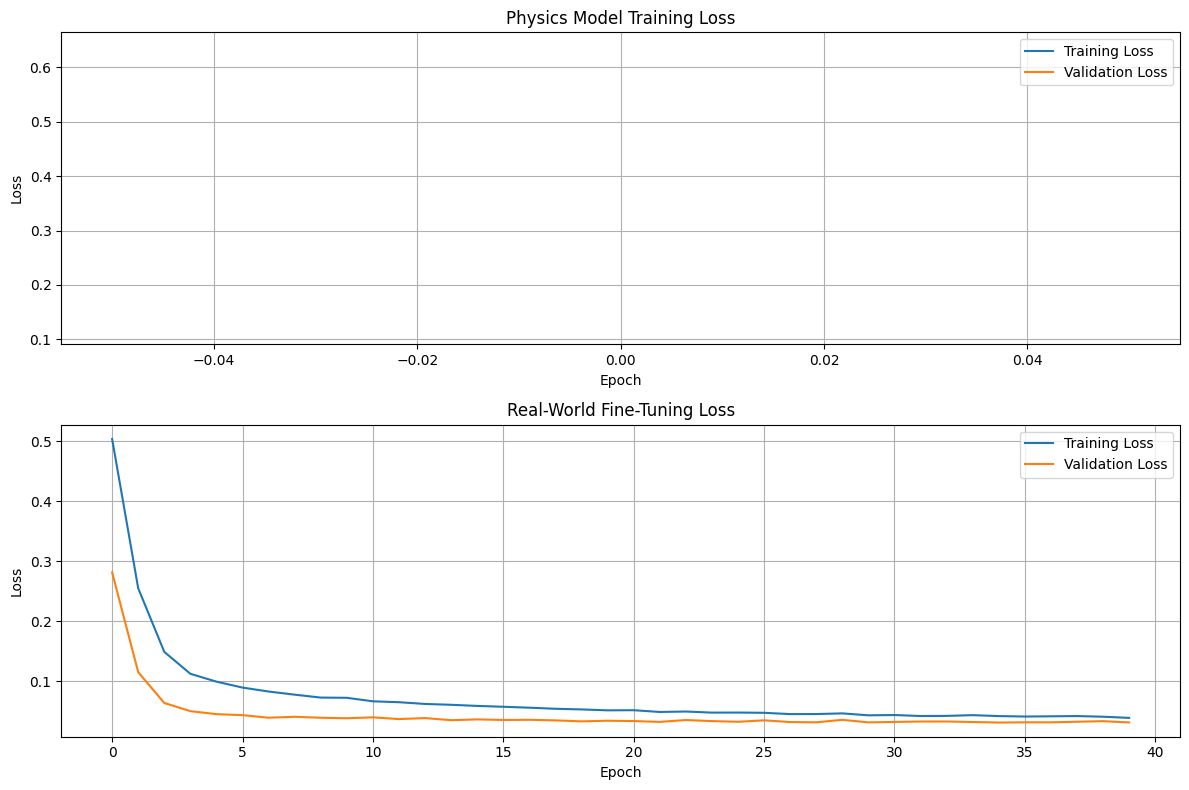

In [14]:
# Extract training losses from history data
physics_train_losses = [epoch['train_loss'] for epoch in physics_history]
physics_val_losses = [epoch['val_loss'] for epoch in physics_history]
real_train_losses = [epoch['train_loss'] for epoch in real_history]
real_val_losses = [epoch['val_loss'] for epoch in real_history]

# Create figure for loss plots
plt.figure(figsize=(12, 8))

# Plot physics training loss
plt.subplot(2, 1, 1)
plt.plot(physics_train_losses, label='Training Loss')
plt.plot(physics_val_losses, label='Validation Loss')
plt.title('Physics Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot real-world fine-tuning loss
plt.subplot(2, 1, 2)
plt.plot(real_train_losses, label='Training Loss')
plt.plot(real_val_losses, label='Validation Loss')
plt.title('Real-World Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(log_dir / "loss_curves.png")
plt.show()

<div dir="rtl">

## Part 6: ניתוח תוצאות האימון - Analysis of Training Results

נביט בחיזויים של המודל המכוונן על נתוני האמת, ביחס לחיזוי שמתבצע עם נוסחאות הפיזיקה.

בכל גרף ציר X יהיה הערך שנחזה עם נוסחאות הפיזיקה, ובציר Y יהיה חיזוי המודל. המקרה של התאמה מושלמת נצפה על קו אלכסוני (y=x).

ניתן לראות שהמודל המאומן על נוסחאות הפיזיקה מתאים בדיוק לנוסחאות הפיזיקה, כך שהאימון שלו היה מוצלח.

ניתן לראות את אי-ההסכמה של המודל המכוונן על נתוני האמת, מה שמסמן שנלמד שינוי מסויים, אותו רצינו למצוא. בתקווה, שינוי זה הוא הדיוק שחיפשנו לסימולציית הפיזיקה.
</div>

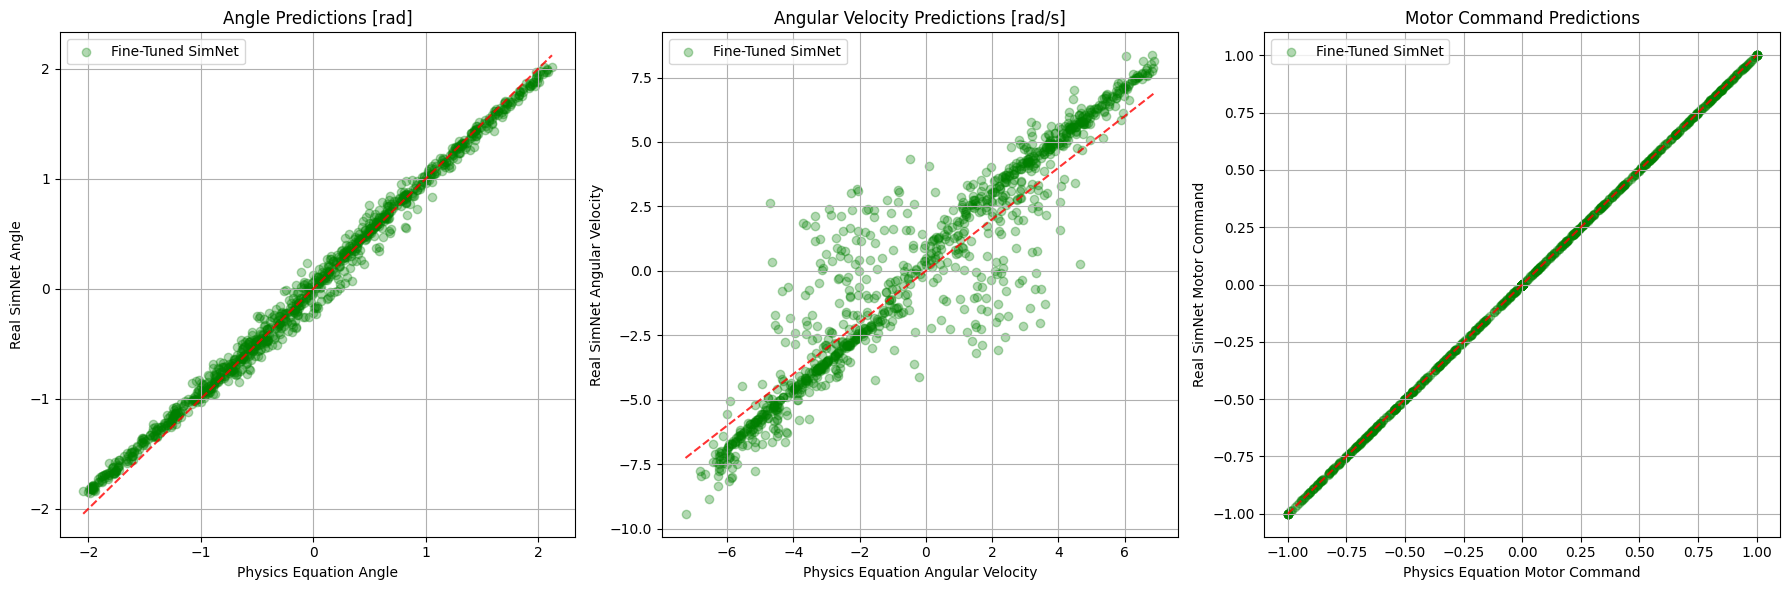

In [15]:
test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions from fine-tuned model
simnet_preds = []

for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    
    # Get prediction from fine-tuned SimNet model
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)

simnet_preds = np.array(simnet_preds)

def plot_state_predictions(physics_preds, simnet_preds, save_path=None):
    """Plot predictions comparing physics equations with fine-tuned SimNet."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot angle predictions (index 0 is theta)
    axes[0].scatter(physics_preds[:, 0], simnet_preds[:, 0], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 0]), max(physics_preds[:, 0])
    axes[0].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[0].set_xlabel("Physics Equation Angle")
    axes[0].set_ylabel("Real SimNet Angle")
    axes[0].set_title("Angle Predictions [rad]")
    axes[0].grid(True)
    axes[0].legend()
    
    # Plot angular velocity predictions (index 1 is theta_dot)
    axes[1].scatter(physics_preds[:, 1], simnet_preds[:, 1], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 1]), max(physics_preds[:, 1])
    axes[1].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[1].set_xlabel("Physics Equation Angular Velocity")
    axes[1].set_ylabel("Real SimNet Angular Velocity")
    axes[1].set_title("Angular Velocity Predictions [rad/s]")
    axes[1].grid(True)
    axes[1].legend()
    
    # Plot motor command predictions (index 2 is prev_motor_command)
    axes[2].scatter(physics_preds[:, 2], simnet_preds[:, 2], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 2]), max(physics_preds[:, 2])
    axes[2].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[2].set_xlabel("Physics Equation Motor Command")
    axes[2].set_ylabel("Real SimNet Motor Command")
    axes[2].set_title("Motor Command Predictions")
    axes[2].grid(True)
    axes[2].legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    return fig

# Use improved function for visualization - comparing real SimNet with physics equations
fig = plot_state_predictions(
    physics_preds=physics_preds,
    simnet_preds=simnet_preds,
    save_path=log_dir / "real_vs_physics_comparison.png",
)
plt.show()

<div dir="rtl">

## Part 7: הערכת ביצועים במרחב המצבים - Evaluation of Performance in State-Space

נביט על ההבדלים בין נוסחאות הפיזיקה והמודל המכוונן על נתוני האמת עבור האיברים השונים במצב המערכת:
- בנתוני הזווית והמהירות הזוויתית, יש שינוי מסוים בין נוסחאות הפיזיקה והמודל המכוונן על נתוני האמת, מה שמראה את ההתאמות שנלמדו.
- בנתוני פלט המנוע הקודם, אין שינוי כלל, וזה סימון טוב כיוון שנתוני פלט המנוע הקודם בכל שלב אמורים להיות זהים לפעולה שהופעלה במצב הקודם.
</div>

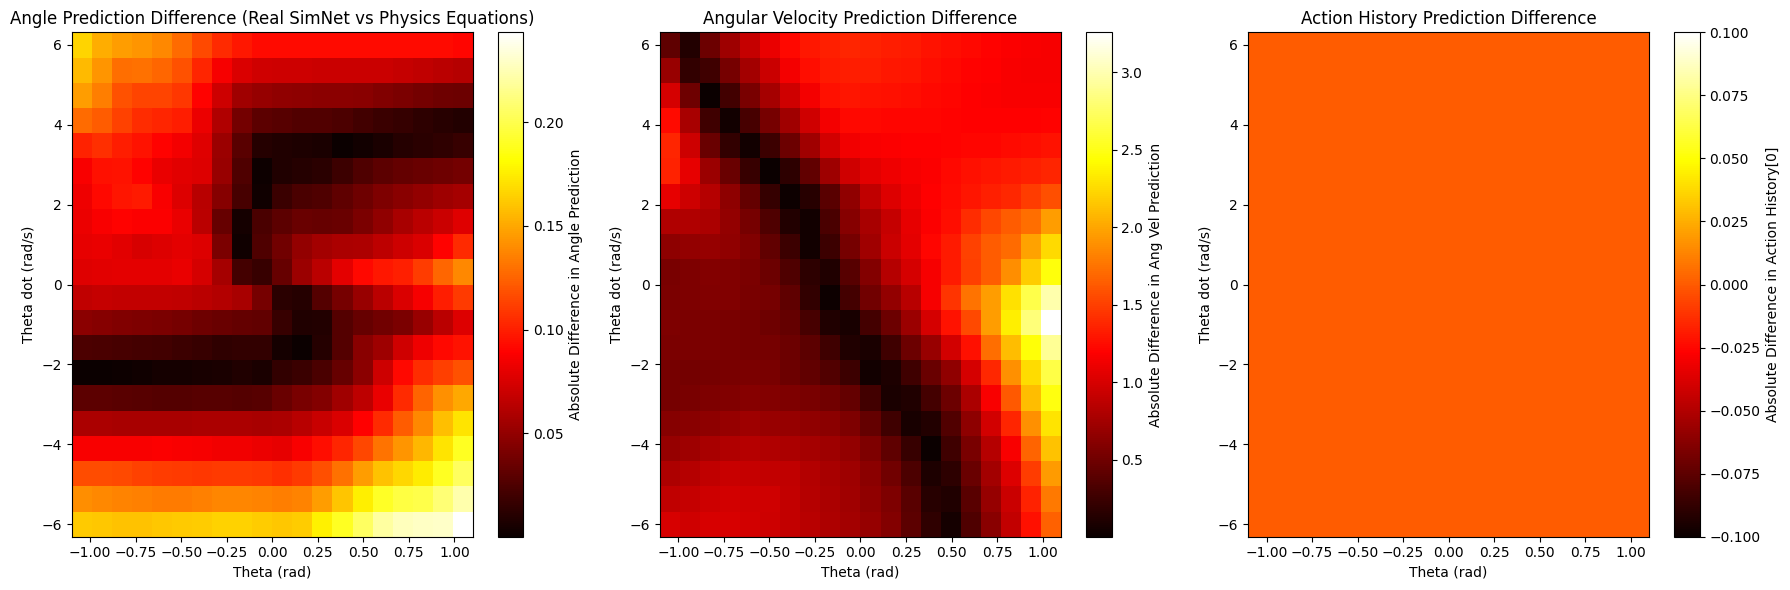

In [16]:
# Create a grid of test points across the state space for the first two dimensions
theta_range = np.linspace(-np.pi / 3, np.pi / 3, 20)
theta_dot_range = np.linspace(-6, 6, 20)
theta_grid, theta_dot_grid = np.meshgrid(theta_range, theta_dot_range)

# Flatten the grid and create enhanced states
test_grid_states = []
for theta, theta_dot in zip(theta_grid.flatten(), theta_dot_grid.flatten()):
    # Create basic state
    basic_state = np.array([theta, theta_dot])

    # Create simulated action history (all zeros)
    action_history = np.zeros(4)  # 4 previous action values

    # Create simulated theta history (use current theta value)
    theta_history = np.ones(3) * theta  # 3 previous theta values

    # Create simulated theta_dot history (use current theta_dot value)
    theta_dot_history = np.ones(3) * theta_dot  # 3 previous theta_dot values

    # Combine into enhanced state (12 elements total)
    enhanced_state = np.concatenate(
        [
            basic_state,  # theta, theta_dot (2 elements)
            action_history,  # 4 previous actions
            theta_history,  # 3 previous theta values
            theta_dot_history,  # 3 previous theta_dot values
        ]
    )

    test_grid_states.append(enhanced_state)

test_grid_states = np.array(test_grid_states)

# Test both models on this grid with a zero action
test_grid_actions = np.zeros((len(test_grid_states), 1))

# Get predictions from real SimNet model
grid_simnet_preds = []

for s, a in zip(test_grid_states, test_grid_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)

    # Get prediction from fine-tuned model
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    grid_simnet_preds.append(pred_next)

grid_simnet_preds = np.array(grid_simnet_preds)

# Calculate physics predictions for the same grid using the physics engine
grid_physics_preds = []
for s, a in zip(test_grid_states, test_grid_actions):
    # Extract basic state for physics engine
    basic_state = s[:2]  # Just theta and theta_dot
    
    # Use physics engine to calculate acceleration
    theta_ddot = env.physics.get_acceleration(basic_state, a[0] * env.max_torque)
    
    # Integrate to get next state
    next_basic_state = env.physics.integrate_state(basic_state, theta_ddot)
    
    # Create full next state by copying the input state and updating theta and theta_dot
    next_state = s.copy()
    next_state[0] = next_basic_state[0]  # Update theta
    next_state[1] = next_basic_state[1]  # Update theta_dot
    
    grid_physics_preds.append(next_state)

grid_physics_preds = np.array(grid_physics_preds)

# Calculate the absolute difference between real SimNet and physics equations
prediction_diff = np.abs(grid_simnet_preds - grid_physics_preds)
diff_angle = prediction_diff[:, 0].reshape(theta_dot_grid.shape)
diff_angular_vel = prediction_diff[:, 1].reshape(theta_dot_grid.shape)
diff_action_history = prediction_diff[:, 2].reshape(theta_dot_grid.shape)

# Plot the difference as a heatmap
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angle, cmap="hot")
plt.colorbar(label="Absolute Difference in Angle Prediction")
plt.title("Angle Prediction Difference (Real SimNet vs Physics Equations)")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.subplot(1, 3, 2)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angular_vel, cmap="hot")
plt.colorbar(label="Absolute Difference in Ang Vel Prediction")
plt.title("Angular Velocity Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.subplot(1, 3, 3)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_action_history, cmap="hot")
plt.colorbar(label="Absolute Difference in Action History[0]")
plt.title("Action History Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.tight_layout()
plt.savefig(log_dir / "real_vs_physics_difference_heatmap.png")
plt.show()

<div dir="rtl">

## שמירת המודל הסופי - Final Model Saving

</div>

In [17]:
# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'real_history': real_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')